<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [22]:
from pprint import pprint
import glob
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk

import run_tissuecyte_stitching_classic

In [23]:
def load_image(image_path):
    image = sitk.ReadImage(str(image_path))
    image = sitk.GetArrayFromImage(image)
    image[image<0] = 0
    image = image.T
    #image = np.flip(image,axis=1)
    #image = np.flip(image,axis=2)
    image = np.squeeze(image)
    return image

def preprocess(img: np.ndarray, min_val: float = None, max_val: float = 400) -> np.ndarray:
    """
    FOR VISUALIZATION PURPOSES
    Preprocesses volume data. Clips maximum value at max_val and then normalizes volume
    between 0-255.
    """
    data = img.copy()
    data[data > max_val] = max_val
    if min_val:
        data[data < min_val] = min_val
    data = cv2.normalize(src=data, dst=None, alpha=0, beta=255, 
                         norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    return data

def auto_contrast(data: np.ndarray, alpha: float = None, beta: float = None) -> np.ndarray:
    """
    Preprocess tiff files to automatically adjust brightness and contrast.
    https://stackoverflow.com/questions/56905592/automatic-contrast-and-brightness-adjustment-of-a-color-photo-of-a-sheet-of-pape
    """
    if not alpha:
        alpha = np.iinfo(data.dtype).max / (np.max(data) - np.min(data))
    if not beta:
        beta = -np.min(data) * alpha
    img = cv2.convertScaleAbs(data, alpha=alpha, beta=beta)
    return img

def adjust_average_tiles(tiles: np.ndarray, multiplier=1.0) -> np.ndarray:
    """
    Adjusts the average tiles to be a different value based on a multiplier.
    """
    return tiles.copy() * multiplier

## Load data

In [24]:
# Input folder parameters
tile_folder = "../B0070/tiles/"
#average_folder = "../B0070/stitched_avg_all_tiles/avg_tiles/"
average_folder = "../B0070/stitched_median/avg_tiles/"

# Get relevant paths
average_paths = glob.glob(average_folder + "/*.tif")
tile_paths = glob.glob(tile_folder + "/*/")
print("Average tiles:")
pprint(average_paths)
print("\nTile folders:")
pprint(tile_paths)

# Generate starting info
print("Creating stitching JSON for sections")
root_dir = tile_folder
depth = 1
sectionNum = 0
mosaic_data, section_jsons = run_tissuecyte_stitching_classic.get_section_data(root_dir, depth, sectionNum)
average_tiles = np.array([run_tissuecyte_stitching_classic.load_average_tile(p) for p in average_paths])
print("Average tiles shape:", average_tiles.shape)

Average tiles:
['../B0070/stitched_median/avg_tiles\\avg_tile_0.tif',
 '../B0070/stitched_median/avg_tiles\\avg_tile_1.tif',
 '../B0070/stitched_median/avg_tiles\\avg_tile_2.tif',
 '../B0070/stitched_median/avg_tiles\\avg_tile_3.tif']

Tile folders:
['../B0070/tiles\\231023_B0070_MR-0001\\',
 '../B0070/tiles\\231023_B0070_MR-0002\\',
 '../B0070/tiles\\231023_B0070_MR-0003\\',
 '../B0070/tiles\\231023_B0070_MR-0004\\',
 '../B0070/tiles\\231023_B0070_MR-0005\\',
 '../B0070/tiles\\231023_B0070_MR-0006\\',
 '../B0070/tiles\\231023_B0070_MR-0007\\',
 '../B0070/tiles\\231023_B0070_MR-0008\\',
 '../B0070/tiles\\231023_B0070_MR-0009\\',
 '../B0070/tiles\\231023_B0070_MR-0010\\',
 '../B0070/tiles\\231023_B0070_MR-0011\\',
 '../B0070/tiles\\231023_B0070_MR-0012\\',
 '../B0070/tiles\\231023_B0070_MR-0013\\',
 '../B0070/tiles\\231023_B0070_MR-0014\\',
 '../B0070/tiles\\231023_B0070_MR-0015\\',
 '../B0070/tiles\\231023_B0070_MR-0016\\',
 '../B0070/tiles\\231023_B0070_MR-0017\\',
 '../B0070/tiles\\2

Average tile ch0 mean: 2.4769323
Average tile ch0 median: 0.9433777
Average tile ch0 min: 0.0
Average tile ch0 max: 45569.63


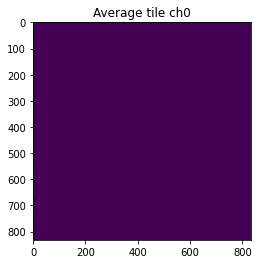

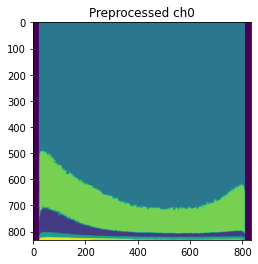

In [25]:
# Show average tiles
print("Average tile ch0 mean:", np.mean(average_tiles[0]))
print("Average tile ch0 median:", np.median(average_tiles[0]))
print("Average tile ch0 min:", np.min(average_tiles[0]))
print("Average tile ch0 max:", np.max(average_tiles[0]))

plt.title("Average tile ch0")
plt.imshow(average_tiles[0], cmap="viridis")
plt.show()

avg0_prepreprocessed = preprocess(average_tiles[0], 0, 255) * 100
plt.title("Preprocessed ch0")
plt.imshow(avg0_prepreprocessed, cmap="viridis")
plt.show()

In [26]:
# Try stitching a single tile
stitch_index = 59
multiplier = 1.0
output_dir = "output/"

# Check if directory exists and create it if it doesn't exist
if not os.path.exists(output_dir + "/stitched_ch0/"):
    os.makedirs(output_dir + "/stitched_ch0/")
if not os.path.exists(output_dir + "/stitched_ch1/"):
    os.makedirs(output_dir + "/stitched_ch1/")
if not os.path.exists(output_dir + "/stitched_ch2/"):
    os.makedirs(output_dir + "/stitched_ch2/")
if not os.path.exists(output_dir + "/stitched_ch3/"):
    os.makedirs(output_dir + "/stitched_ch3/")

# Stitching parameters
curr_section = section_jsons[stitch_index]
save_undistorted = False

# Adjust average tiles
#average_tiles = adjust_average_tiles(average_tiles, multiplier)
#average_tiles[average_tiles != -9999] = 1.0

#average_paths = glob.glob("../B0013/stitched/avg_tiles/" + "/*.tif")
#average_tiles = np.array([run_tissuecyte_stitching_classic.load_average_tile(p) for p in average_paths])


run_tissuecyte_stitching_classic.stitch_section(curr_section, average_tiles, output_dir, save_undistorted)

INFO:root:image_dimensions: {'row': 11236, 'column': 8716}


output/stitched_ch0\231023_B0070_MR-0060_1_0.tif
output/stitched_ch1\231023_B0070_MR-0060_1_1.tif
output/stitched_ch2\231023_B0070_MR-0060_1_2.tif
output/stitched_ch3\231023_B0070_MR-0060_1_3.tif


## Visualize stitched sections

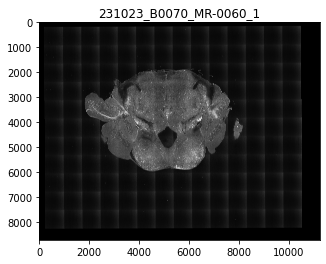

In [27]:
# Median 20 with no application on black tiles
channel = 0

# Show the stitched tile
output_path = output_dir + "/stitched_ch0/" + curr_section['slice_fname'] + "_" + str(channel) + ".tif"
#output_path = glob.glob(output_path + "/*.tif")[0]
output_tile = load_image(output_path)
processed_tile = auto_contrast(output_tile, alpha=1.0)
#processed_tile = preprocess(output_tile, 0, 400)

plt.title(curr_section['slice_fname'])
plt.imshow(processed_tile, cmap="gray")
plt.show()

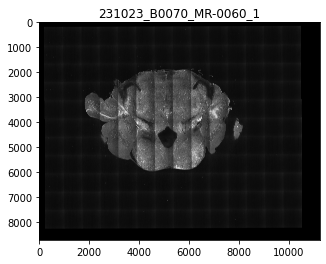

In [9]:
# B0013
channel = 0

# Show the stitched tile
output_path = output_dir + "/stitched_ch0/" + curr_section['slice_fname'] + "_" + str(channel) + ".tif"
#output_path = glob.glob(output_path + "/*.tif")[0]
output_tile = load_image(output_path)
processed_tile = auto_contrast(output_tile, alpha=1.0)
#processed_tile = preprocess(output_tile, 0, 400)

plt.title(curr_section['slice_fname'])
plt.imshow(processed_tile, cmap="gray")
plt.show()

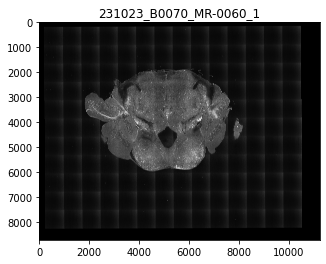

In [7]:
# Median 20
channel = 0

# Show the stitched tile
output_path = output_dir + "/stitched_ch0/" + curr_section['slice_fname'] + "_" + str(channel) + ".tif"
#output_path = glob.glob(output_path + "/*.tif")[0]
output_tile = load_image(output_path)
processed_tile = auto_contrast(output_tile, alpha=1.0)
#processed_tile = preprocess(output_tile, 0, 400)

plt.title(curr_section['slice_fname'])
plt.imshow(processed_tile, cmap="gray")
plt.show()

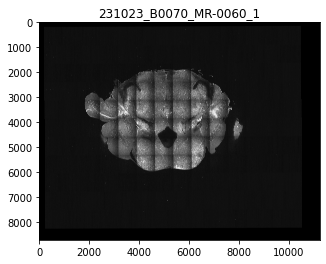

In [46]:
# No average tile adjustment

channel = 0

# Show the stitched tile
output_path = output_dir + "/stitched_ch0/" + curr_section['slice_fname'] + "_" + str(channel) + ".tif"
#output_path = glob.glob(output_path + "/*.tif")[0]
output_tile = load_image(output_path)
processed_tile = auto_contrast(output_tile, alpha=1.0)
#processed_tile = preprocess(output_tile, 0, 400)

plt.title(curr_section['slice_fname'])
plt.imshow(processed_tile, cmap="gray")
plt.show()

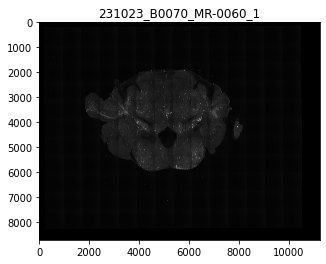

In [32]:
# 0.25

channel = 0

# Show the stitched tile
output_path = output_dir + "/stitched_ch0/" + curr_section['slice_fname'] + "_" + str(channel) + ".tif"
#output_path = glob.glob(output_path + "/*.tif")[0]
output_tile = load_image(output_path)
processed_tile = auto_contrast(output_tile, alpha=1.0)
#processed_tile = preprocess(output_tile, 0, 400)

plt.title(curr_section['slice_fname'])
plt.imshow(processed_tile, cmap="gray")
plt.show()

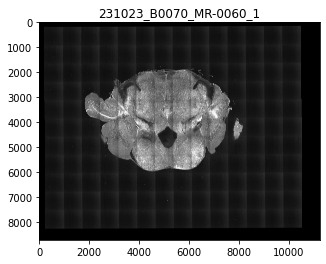

In [30]:
# 0.5

channel = 0

# Show the stitched tile
output_path = output_dir + "/stitched_ch0/" + curr_section['slice_fname'] + "_" + str(channel) + ".tif"
#output_path = glob.glob(output_path + "/*.tif")[0]
output_tile = load_image(output_path)
processed_tile = auto_contrast(output_tile, alpha=1.0)
#processed_tile = preprocess(output_tile, 0, 400)

plt.title(curr_section['slice_fname'])
plt.imshow(processed_tile, cmap="gray")
plt.show()

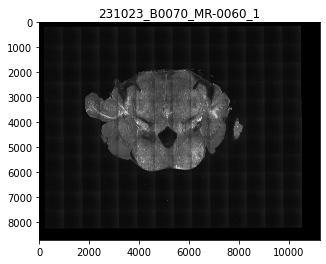

In [26]:
# 1.0

channel = 0

# Show the stitched tile
output_path = output_dir + "/stitched_ch0/" + curr_section['slice_fname'] + "_" + str(channel) + ".tif"
#output_path = glob.glob(output_path + "/*.tif")[0]
output_tile = load_image(output_path)
processed_tile = auto_contrast(output_tile, alpha=1.0)
#processed_tile = preprocess(output_tile, 0, 400)

plt.title(curr_section['slice_fname'])
plt.imshow(processed_tile, cmap="gray")
plt.show()

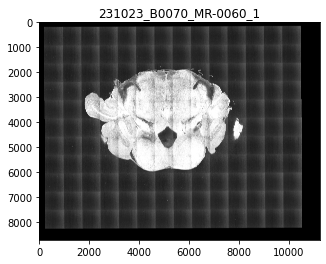

In [28]:
# 3.0

channel = 0

# Show the stitched tile
output_path = output_dir + "/stitched_ch0/" + curr_section['slice_fname'] + "_" + str(channel) + ".tif"
#output_path = glob.glob(output_path + "/*.tif")[0]
output_tile = load_image(output_path)
processed_tile = auto_contrast(output_tile, alpha=1.0)
#processed_tile = preprocess(output_tile, 0, 400)

plt.title(curr_section['slice_fname'])
plt.imshow(processed_tile, cmap="gray")
plt.show()

## Visualize sample tiles

Mean: 17.27208100268121
Median: 18.0
Min: 0
Max: 547


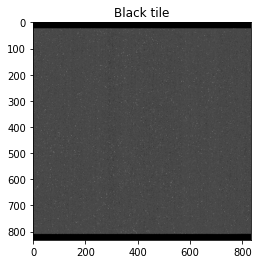

In [63]:
# Black tile
black_tile = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9092_02.tif"
black_tile = load_image(black_tile)

# Get stats
print("Mean:", np.mean(black_tile))
print("Median:", np.median(black_tile))
print("Min:", np.min(black_tile))
print("Max:", np.max(black_tile))

# Modify the tile for visualization
black_tile = auto_contrast(black_tile, alpha=4.0)
plt.title("Black tile")
plt.imshow(black_tile, cmap="gray")
plt.show()

Mean: 17.229801335983726
Median: 18.0
Min: 0
Max: 6121


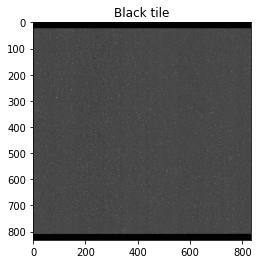

In [62]:
# Black tile
black_tile = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9090_02.tif"
black_tile = load_image(black_tile)

# Get stats
print("Mean:", np.mean(black_tile))
print("Median:", np.median(black_tile))
print("Min:", np.min(black_tile))
print("Max:", np.max(black_tile))

# Modify the tile for visualization
black_tile = auto_contrast(black_tile, alpha=4.0)
plt.title("Black tile")
plt.imshow(black_tile, cmap="gray")
plt.show()

Mean: 17.653092062684912
Median: 16.0
Min: 0
Max: 1710


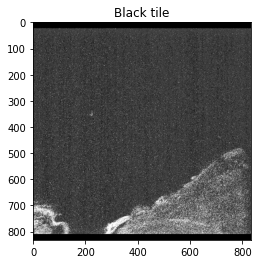

In [58]:
# Tissue tile
black_tile = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9118_01.tif"
black_tile = load_image(black_tile)

# Get stats
print("Mean:", np.mean(black_tile))
print("Median:", np.median(black_tile))
print("Min:", np.min(black_tile))
print("Max:", np.max(black_tile))

# Modify the tile for visualization
black_tile = auto_contrast(black_tile, alpha=4.0)
plt.title("Black tile")
plt.imshow(black_tile, cmap="gray")
plt.show()

Mean: 43.408038438424555
Median: 20.0
Min: 0
Max: 4457


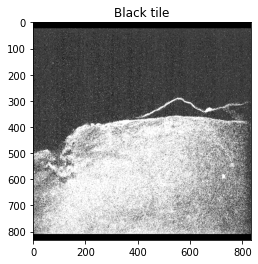

In [59]:
# Tissue tile
black_tile = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9119_01.tif"
black_tile = load_image(black_tile)

# Get stats
print("Mean:", np.mean(black_tile))
print("Median:", np.median(black_tile))
print("Min:", np.min(black_tile))
print("Max:", np.max(black_tile))

# Modify the tile for visualization
black_tile = auto_contrast(black_tile, alpha=4.0)
plt.title("Black tile")
plt.imshow(black_tile, cmap="gray")
plt.show()

Mean: 54.30651060928255
Median: 42.0
Min: 0
Max: 21967


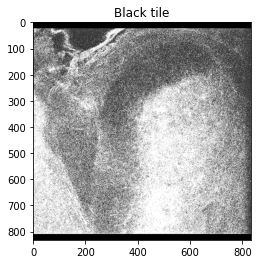

In [61]:
# Tissue tile
black_tile = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9137_01.tif"
black_tile = load_image(black_tile)

# Get stats
print("Mean:", np.mean(black_tile))
print("Median:", np.median(black_tile))
print("Min:", np.min(black_tile))
print("Max:", np.max(black_tile))

# Modify the tile for visualization
black_tile = auto_contrast(black_tile, alpha=4.0)
plt.title("Black tile")
plt.imshow(black_tile, cmap="gray")
plt.show()

Mean: 96.9022686298077
Median: 83.0
Min: 0
Max: 7996


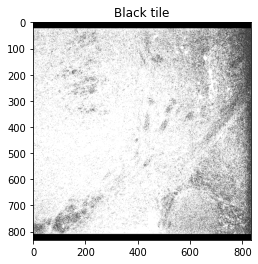

In [60]:
# Tissue tile
black_tile = "../B0070/tiles/231023_B0070_MR-0060/10232023-1246-9150_01.tif"
black_tile = load_image(black_tile)

# Get stats
print("Mean:", np.mean(black_tile))
print("Median:", np.median(black_tile))
print("Min:", np.min(black_tile))
print("Max:", np.max(black_tile))

# Modify the tile for visualization
black_tile = auto_contrast(black_tile, alpha=4.0)
plt.title("Black tile")
plt.imshow(black_tile, cmap="gray")
plt.show()

# Tissue tile
black_tile = "../B0070/tiles/231023_B0070_MR-0060/*.tif"
expaths = glob.glob(black_tile)
for p in expaths:
    curr_tile = load_image(p)

    # Modify the tile for visualization
    curr_tile = auto_contrast(curr_tile, alpha=4.0)
    plt.title(p)
    plt.imshow(curr_tile, cmap="gray")
    plt.show()